# NFA prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
output_folder = './validation_report/NFA'
today = pd.Timestamp.today().strftime('%Y-%m-%d')

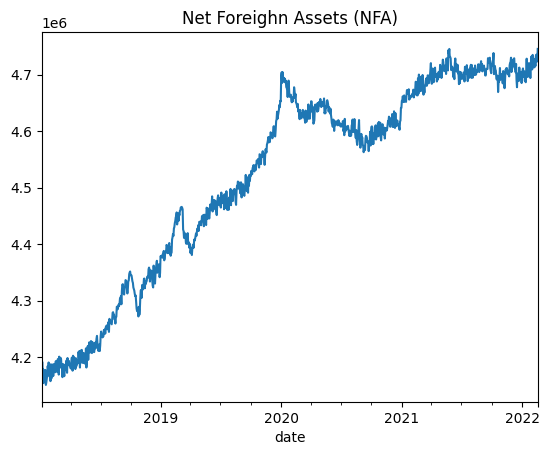

In [3]:
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')
NFA['NFA'].plot(title = 'Net Foreighn Assets (NFA)'); plt.show()

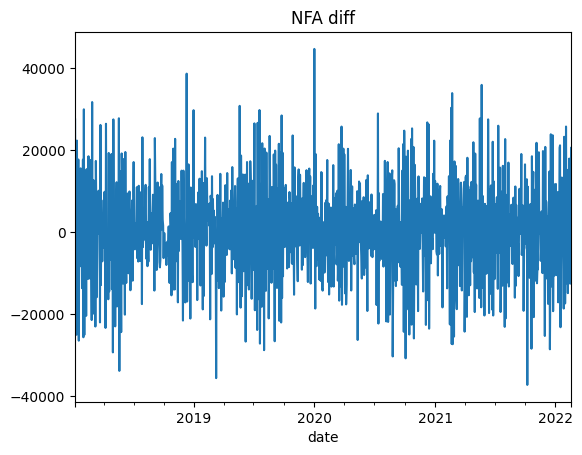

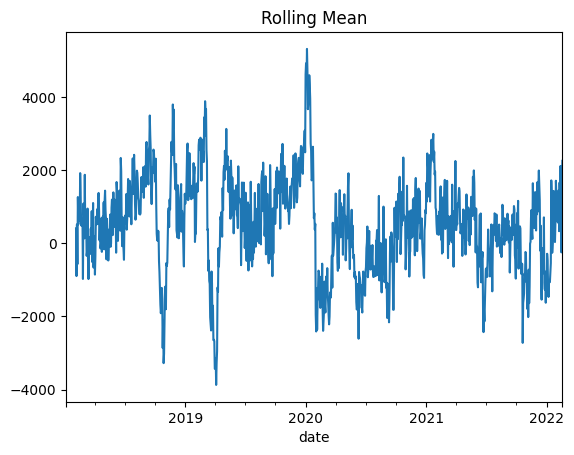

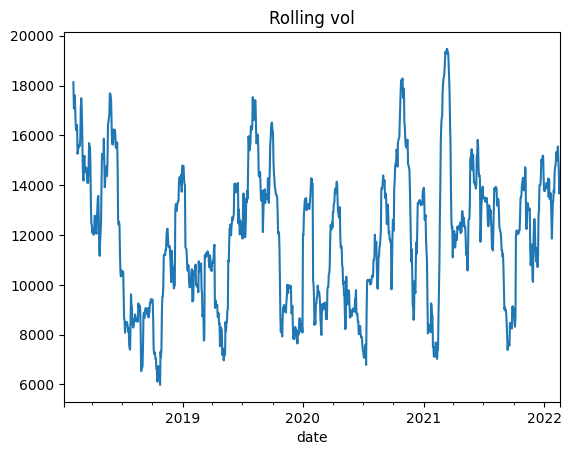

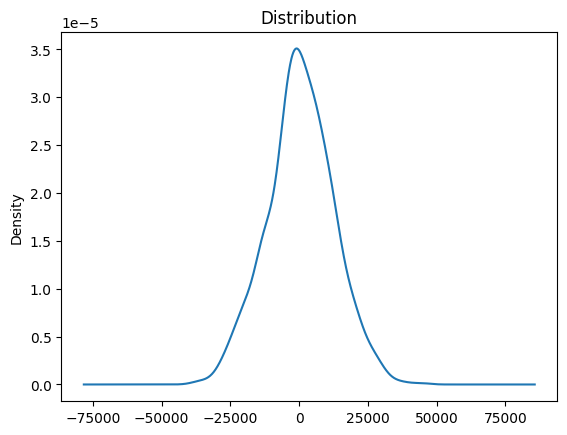

In [4]:
NFA_diff = NFA['NFA'].diff().dropna()
NFA_diff.plot(title = 'NFA diff');plt.show()
NFA_diff.rolling(22).mean().plot(title = 'Rolling Mean');plt.show()
NFA_diff.rolling(22).std().plot(title = 'Rolling vol');plt.show()
NFA_diff.plot(kind='kde', title = 'Distribution');plt.show()

In [5]:
dateindex = pd.date_range(start=NFA.index[0], 
                             end=NFA.index[-1] + pd.Timedelta(days=365),
                            freq='B')
exogs = pd.DataFrame(index=dateindex)

exogs['trend'] = np.arange(len(exogs))
# Define seasonalities based on your original expressions
exogs['yearly_season'] = np.sin(2 * np.pi * exogs['trend'] / 260)  # Assuming 260 working days per year for yearly seasonality
exogs['monthly_season'] = np.sin(2 * np.pi * exogs['trend'] / 22)  # Assuming about 22 working days per month
exogs['weekly_season'] = np.sin(2 * np.pi * exogs['trend'] / 5)   # Assuming 5 working days per week
exogs['break'] = np.where(exogs.index > '2020-01-06', 1., 0.)

# Now data contains the extended series with seasonal components
data = NFA.merge(exogs, left_index=True, right_index=True, how='left')
data.tail()


,NFA,trend,yearly_season,monthly_season,weekly_season,break
date,,,,,,
2022-02-14,4733120,1073,0.715599,-0.989821,-5.877853e-01,1.0
2022-02-15,4735390,1074,0.732269,-0.909632,-9.510565e-01,1.0
2022-02-16,4722792,1075,0.748511,-0.755750,-8.818695e-14,1.0
2022-02-17,4724983,1076,0.764316,-0.540641,9.510565e-01,1.0
2022-02-18,4745512,1077,0.779674,-0.281733,5.877853e-01,1.0


## Section 2: Model Definition

In [6]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.arch import ARCH  

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(trend=False),
    "AutoETS": StatsForecastAutoETS(season_length=5),
    "AutoCES": StatsForecastAutoCES(season_length=5),
    "AutoTheta": StatsForecastAutoTheta(season_length=5),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=5, use_trend =True, use_boxcox=True),
    'GARCH':  ARCH(mean='ARX', lags=5, vol='GARCH')
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'NFA',                 
            exog_l=['break'],
            model_exog_d = {'GARCH': ['trend', 'yearly_season',
                                      'monthly_season', 'weekly_season']},
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


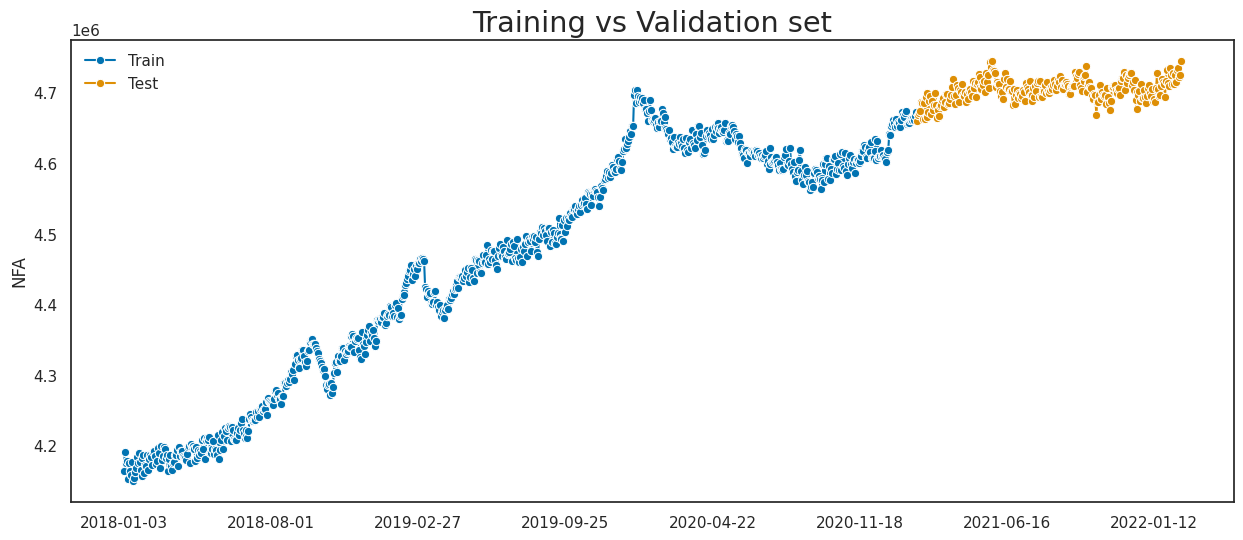

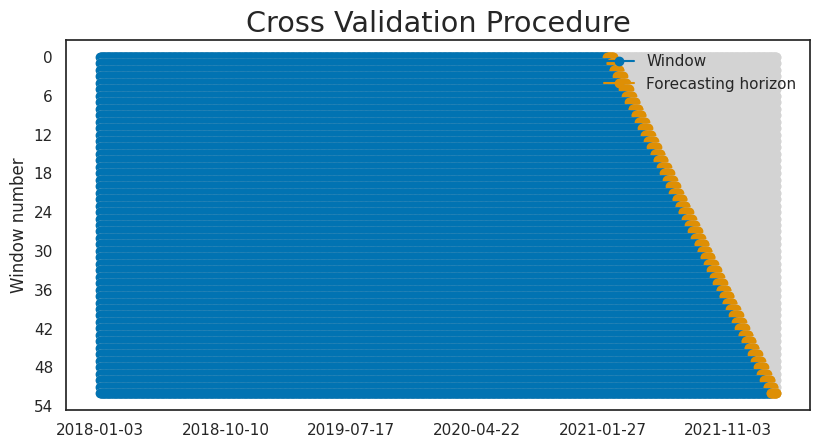

In [7]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')
plt.savefig(os.path.join(output_folder, f'train_test_{today}.png'), dpi=300)
model.plot_cv_procedure(xlabel='')
plt.savefig(os.path.join(output_folder, f'cross_validation_{today}.png'), dpi=300)

### Out-Of-sample Evaluation

In [8]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 85.17it/s]


Evaluation completed in: 0 seconds
Fitting the model Naive on the entire sample ...
Model fitted in 0 seconds

Start Seasonal_Naive forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 113.19it/s]


Evaluation completed in: 0 seconds
Fitting the model Seasonal_Naive on the entire sample ...
Model fitted in 0 seconds

Start AutoARIMA forecaster evaluation....


100%|██████████| 51/51 [00:13<00:00,  3.87it/s]


Evaluation completed in: 14 seconds
Fitting the model AutoARIMA on the entire sample ...
Model fitted in 10 seconds

Start AutoETS forecaster evaluation....


100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


Evaluation completed in: 20 seconds
Fitting the model AutoETS on the entire sample ...
Model fitted in 17 seconds

Start AutoCES forecaster evaluation....


100%|██████████| 51/51 [00:23<00:00,  2.20it/s]


Evaluation completed in: 23 seconds
Fitting the model AutoCES on the entire sample ...
Model fitted in 52 seconds

Start AutoTheta forecaster evaluation....


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Evaluation completed in: 31 seconds
Fitting the model AutoTheta on the entire sample ...
Model fitted in 11 seconds

Start AutoTBATS forecaster evaluation....


100%|██████████| 51/51 [00:10<00:00,  4.71it/s]


Evaluation completed in: 12 seconds
Fitting the model AutoTBATS on the entire sample ...
Model fitted in 7 seconds

Start GARCH forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 320.25it/s]


Evaluation completed in: 0 seconds
Fitting the model GARCH on the entire sample ...
Model fitted in 0 seconds


In [9]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Number of Predictions,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoETS,51,312,19.056968,0.064793,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14147.113504,12197.577048,0.002593,-1.613344,11322.357887
AutoCES,51,312,17.649614,0.053538,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14174.595296,12221.295252,0.002598,-1.627194,11370.331634
AutoTheta,51,312,27.260245,0.071551,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14230.44763,12275.10716,0.002609,-1.616161,11269.684226
AutoTBATS,51,312,9.192132,0.005786,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14359.959337,12398.563238,0.002635,-1.693732,11414.109807
GARCH,51,312,0.02927,0.004057,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14401.96846,12427.095805,0.002641,-1.696661,11477.32853
Naive,51,312,0.004655,0.047099,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14694.203916,12565.54542,0.002671,-1.826779,11608.133588
AutoARIMA,51,312,12.142697,0.189142,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,14657.019621,12668.225654,0.002694,-1.839443,11916.846461
Seasonal_Naive,51,312,0.004676,0.033367,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,15575.247646,13000.780534,0.002763,-2.035929,11942.541985


horizon                            1             2             3   \
Naive          RMSE      13605.517338  14695.731436  14831.376877   
               MAE       10873.679487  12050.381410  12159.794872   
               MAPE          0.002312      0.002561      0.002584   
               R2            0.164686      0.087829      0.025337   
               MedianAE   9063.000000  10823.500000  11236.000000   
Seasonal_Naive RMSE      14623.840000  15011.427987  14995.186208   
               MAE       11725.576923  12094.336538  12188.653846   
               MAPE          0.002492      0.002570      0.002590   
               R2            0.034966      0.048217      0.003688   
               MedianAE   9689.500000  10187.000000  10240.500000   
AutoARIMA      RMSE      14781.584786  15683.857209  15708.726369   
               MAE       11602.852777  12559.049453  12332.234770   
               MAPE          0.002468      0.002672      0.002623   
               R2            0.014035     -0.038962     -0.093386   
               MedianAE   9337.390302  10348.565188  10255.977367   
AutoETS        RMSE      13622.805719  14285.960554  14856.201875   
               MAE       10852.994443  11314.169723  11806.920744   
               MAPE          0.002307      0.002405      0.002510   
               R2            0.162562      0.137989      0.022071   
               MedianAE   9253.820780  10307.005273  10778.460849   
AutoCES        RMSE      13655.415127  14335.983572  14902.829625   
               MAE       10873.185228  11349.607943  11845.915561   
               MAPE          0.002311      0.002412      0.002518   
               R2            0.158548      0.131942      0.015923   
               MedianAE   9295.000000  10385.750000  10815.203003   
AutoTheta      RMSE      13650.818312  14308.588035  14855.474276   
               MAE       10917.415893  11335.278072  11828.984667   
               MAPE          0.002321      0.002409      0.002514   
               R2            0.159114      0.135256      0.022167   
               MedianAE   9321.460555   9904.626247  10599.520988   
AutoTBATS      RMSE      13721.200717  14397.141306  14996.384350   
               MAE       10938.879046  11399.100789  11943.363742   
               MAPE          0.002325      0.002423      0.002538   
               R2            0.150421      0.124520      0.003529   
               MedianAE   9361.815705   9827.778767  10505.861588   
GARCH          RMSE      13712.830390  14451.052820  15125.741933   
               MAE       10990.555250  11442.794403  12068.219335   
               MAPE          0.002336      0.002432      0.002565   
               R2            0.151457      0.117951     -0.013736   
               MedianAE   9274.286739   9442.912657   9864.601473   

horizon                            4             5             6   \
Naive          RMSE      14985.260332  16040.873353  15913.354085   
               MAE       12131.737179  13051.945513  12552.003205   
               MAPE          0.002578      0.002775      0.002668   
               R2           -0.010607     -0.111408     -0.218145   
               MedianAE  10187.000000  11288.000000  10040.500000   
Seasonal_Naive RMSE      15068.012455  16772.657304  16421.380497   
               MAE       12245.041667  13366.756410  13100.451923   
               MAPE          0.002602      0.002842      0.002785   
               R2           -0.021800     -0.215126     -0.297164   
               MedianAE  10418.000000  11929.500000  12161.500000   
AutoARIMA      RMSE      15946.247567  16552.583564  16402.428481   
               MAE       12420.869491  12589.454101  12480.386850   
               MAPE          0.002642      0.002678      0.002654   
               R2           -0.144382     -0.183447     -0.294171   
               MedianAE   9995.202056  10096.303421  10131.531394   
AutoETS        RMSE      15007.664266  15745.906182  15929.757866 

In [10]:
rank, score = model.select_best(score = 'RMSE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,Naive,AutoETS,Naive,Naive,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoTheta
Best_2,AutoETS,AutoTheta,AutoTheta,AutoCES,AutoCES,Naive,AutoETS,AutoETS,GARCH,GARCH
Best_3,AutoTheta,AutoCES,AutoETS,AutoETS,AutoETS,AutoETS,AutoCES,AutoCES,AutoETS,Naive
Best_4,AutoCES,AutoTBATS,AutoCES,Seasonal_Naive,GARCH,AutoCES,GARCH,GARCH,AutoCES,AutoETS
Best_5,GARCH,GARCH,Seasonal_Naive,AutoTheta,AutoTBATS,GARCH,AutoTBATS,AutoTBATS,AutoTBATS,AutoCES
Best_6,AutoTBATS,Naive,AutoTBATS,AutoTBATS,Naive,AutoTBATS,Naive,AutoARIMA,Naive,AutoTBATS
Best_7,Seasonal_Naive,Seasonal_Naive,GARCH,GARCH,AutoARIMA,AutoARIMA,Seasonal_Naive,Naive,Seasonal_Naive,AutoARIMA
Best_8,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,Seasonal_Naive,Seasonal_Naive,AutoARIMA,Seasonal_Naive,AutoARIMA,Seasonal_Naive


,Naive,Seasonal_Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,GARCH,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,,
1,13605.517338,14623.840000,14781.584786,13622.805719,13655.415127,13650.818312,13721.200717,13712.830390,13650.818312,13605.517338,13636.812016,13614.161528,13921.751549
2,14695.731436,15011.427987,15683.857209,14285.960554,14335.983572,14308.588035,14397.141306,14451.052820,14308.588035,14285.960554,14297.274294,14297.274294,14646.217865
3,14831.376877,14995.186208,15708.726369,14856.201875,14902.829625,14855.474276,14996.384350,15125.741933,14855.474276,14831.376877,14855.838076,14843.425577,15033.990189
4,14985.260332,15068.012455,15946.247567,15007.664266,14999.802385,15075.138585,15165.503489,15210.981073,15075.138585,14985.260332,15041.401426,14992.531358,15182.326269
5,16040.873353,16772.657304,16552.583564,15745.906182,15745.248442,15732.083758,15864.146609,15844.585803,15732.083758,15732.083758,15738.994970,15738.666100,16037.260627
6,15913.354085,16421.380497,16402.428481,15929.757866,15998.616871,15876.912175,16099.141010,16085.454169,15876.912175,15876.912175,15903.335021,15895.133130,16090.880644
7,16802.559529,17000.566199,17009.696548,16446.450911,16525.348051,16335.434025,16611.786492,16542.356266,16335.434025,16335.434025,16390.942468,16390.942468,16659.274753
8,16991.946001,17071.834521,16935.870834,16663.867338,16734.518302,16516.412546,16835.453014,16752.941782,16516.412546,16516.412546,16590.139942,16590.139942,16812.855542
9,16769.567148,16784.848802,16954.490906,16490.842043,16526.082617,16305.212289,16623.061081,16469.884974,16305.212289,16305.212289,16398.027166,16387.548631,16615.498732


In [11]:
# export all the result in excel 
with pd.ExcelWriter(os.path.join(output_folder, f'Cross_validation_result_{today}.xlsx')) as writer:
    summary_results.to_excel(writer, sheet_name='summary_results', index=True)
    summary_horizon.to_excel(writer, sheet_name='summary_horizon', index=True)
    rank.to_excel(writer, sheet_name='rank', index=True)
    score.to_excel(writer, sheet_name='score', index=True)

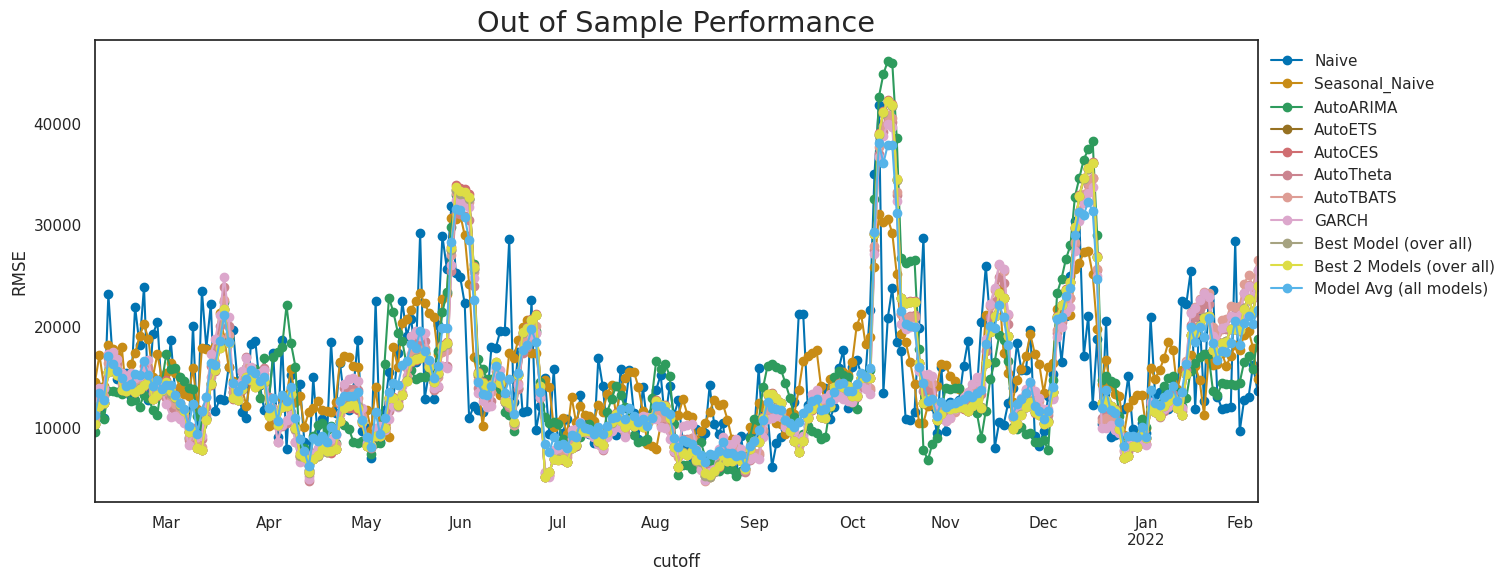

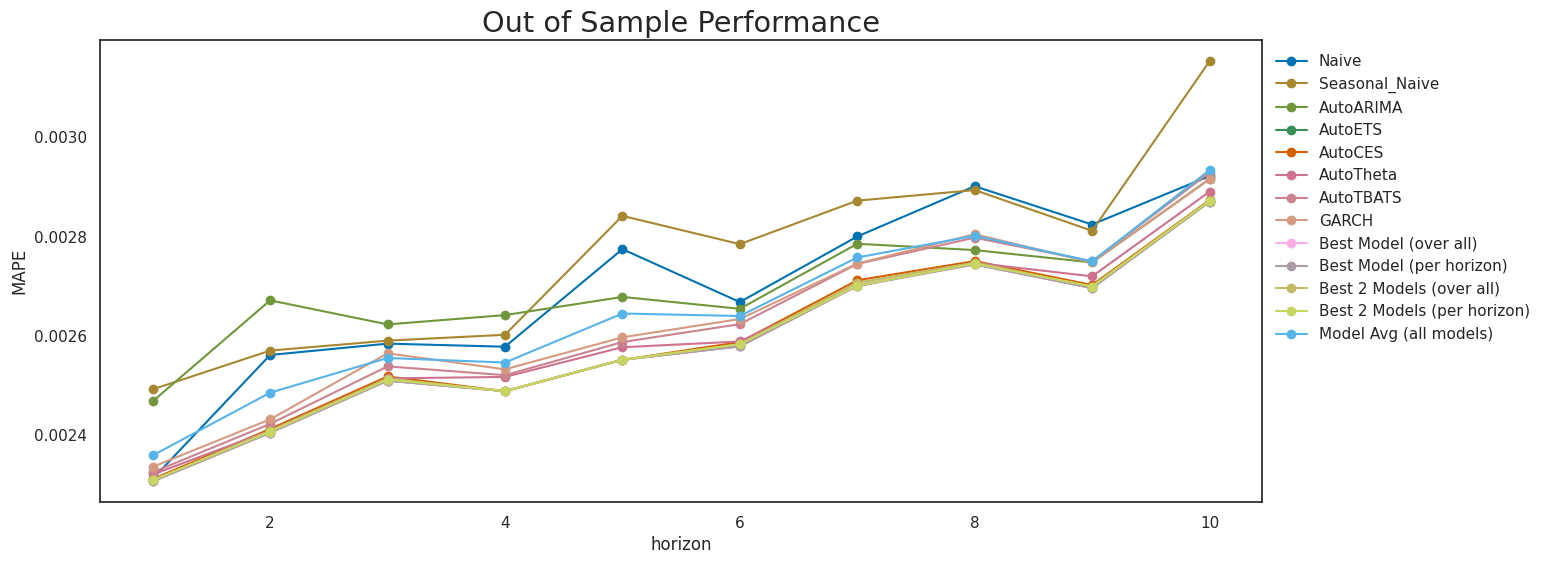

In [12]:
subset = ['AutoCES', 'AutoTheta', 'AutoTBATS', 'GARCH']
model.plot_model_compare(score ='RMSE', view = 'cutoff')#, model_subset=subset)
plt.savefig(os.path.join(output_folder, f'model_compare_per_cutoff_{today}.png'), dpi=300, bbox_inches='tight')
model.plot_model_compare(score ='MAPE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])
plt.savefig(os.path.join(output_folder, f'model_compare_per_horizon_{today}.png'), dpi=300, bbox_inches='tight')

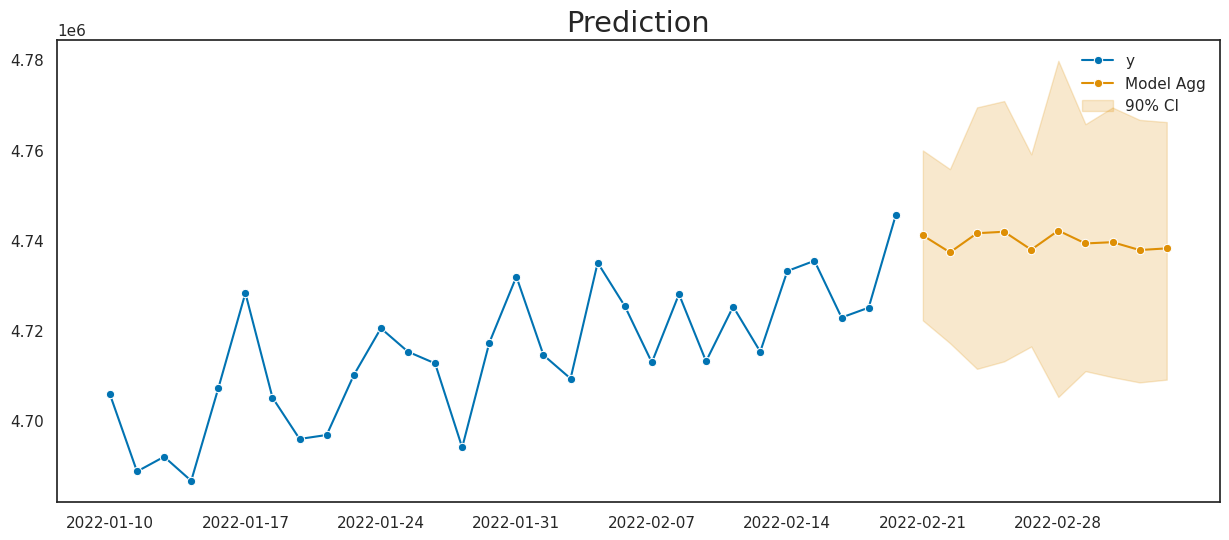

In [13]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(X=exogs,
                                                      mode='nbest_average_horizon',
                                                      ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     y_pred_interval = y_pred_ints)                 

In [14]:
path = '../model_output/NFA_forecast.pkl'
model.save(path)